In [2]:
from openeo_gfmap import BoundingBoxExtent, TemporalContext
from openeo_gfmap.backend import Backend, BackendContext
from worldcereal.job import collect_inputs
from pathlib import Path

### AOI and temporal range specification

In [3]:
bbox_utm = (472767.653613, 5.651370e06, 488748.443236, 5.664161e06)
epsg = 32631

# Defining period of interest for temporary crops product
start_date = "2020-11-01"
end_date = "2021-10-31"
temporal_extent = TemporalContext(start_date, end_date)

# We convert our bounding box to local UTM projection
spatial_extent = BoundingBoxExtent(
    bbox_utm[0], bbox_utm[1], bbox_utm[2], bbox_utm[3], epsg
)

# We specify the cloud backend where computations need to be done
backend_context = BackendContext(Backend.FED)

### Launching a `gfmap` - `openEO` workflow to collect WorldCereal-like preprocessed inputs

In [3]:
# collect_inputs(
#     spatial_extent,
#     temporal_extent,
#     backend_context,
#     output_path=Path.cwd() / 'worldcereal_inputs.nc',
# )

In [4]:
# import openeo

# connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()
# job = connection.job('j-240621f719414f1dbc84619712eacffe')
# job.download_result(Path.cwd() / 'worldcereal_inputs.nc')

### Sanity checks on the preprocessed inputs

In [4]:
import xarray as xr

ds = xr.open_dataset("worldcereal_inputs.nc")
ds = ds.sel(x=slice(481500, 483000), y=slice(5653000, 5650000))
ds

<xarray.Dataset>
Dimensions:        (t: 12, x: 150, y: 163)
Coordinates:
  * t              (t) datetime64[ns] 2020-11-01 2020-12-01 ... 2021-10-01
  * x              (x) float64 4.815e+05 4.815e+05 ... 4.83e+05 4.83e+05
  * y              (y) float64 5.653e+06 5.653e+06 ... 5.651e+06 5.651e+06
Data variables: (12/15)
    crs            |S1 ...
    S2-L2A-B02     (t, y, x) uint16 ...
    S2-L2A-B03     (t, y, x) uint16 ...
    S2-L2A-B04     (t, y, x) uint16 ...
    S2-L2A-B05     (t, y, x) uint16 ...
    S2-L2A-B06     (t, y, x) uint16 ...
    ...             ...
    S2-L2A-B12     (t, y, x) uint16 ...
    S1-SIGMA0-VH   (t, y, x) uint16 ...
    S1-SIGMA0-VV   (t, y, x) uint16 ...
    COP-DEM        (t, y, x) uint16 ...
    AGERA5-PRECIP  (t, y, x) uint16 ...
    AGERA5-TMEAN   (t, y, x) uint16 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.38.6a1
    description:  
    title:

#### Sentinel-2

Matplotlib is building the font cache; this may take a moment.


[2944. 1557. 1546. 2078. 3698. 6428. 6128. 6616. 5196. 4484. 4500.   nan]


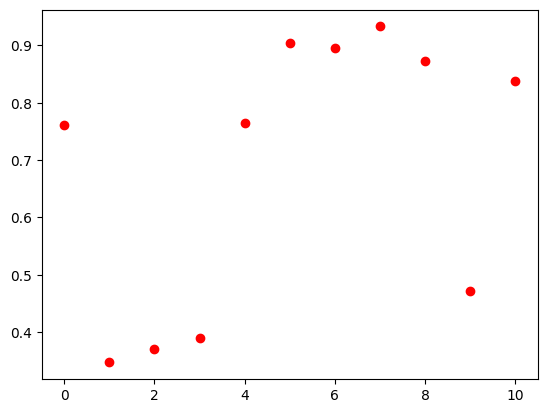

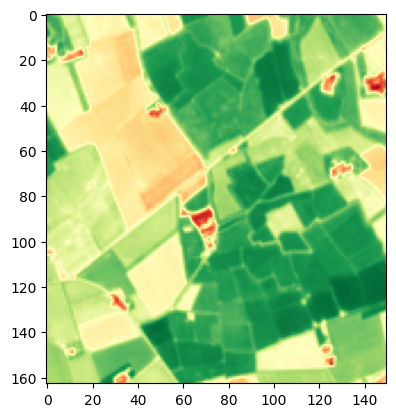

In [6]:
import numpy as np
import matplotlib.pyplot as plt

idx = 140
idy = 140

b08 = ds["S2-L2A-B08"].values.astype(np.float32)
b04 = ds["S2-L2A-B04"].values.astype(np.float32)

b08[b08 == 65535] = np.nan

ndvi = (b08 - b04) / (b08 + b04)
print(b08[:, idx, idy])
plt.plot(ndvi[:, idx, idy], "ro")
plt.show()

plt.imshow(np.nanmean(ndvi, axis=0), cmap="RdYlGn")

TypeError: Image data of dtype object cannot be converted to float

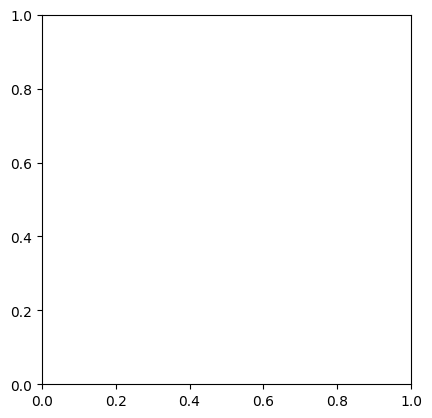

In [116]:
plt.imshow(
    np.median(
        ds.to_array(dim="bands")
        .sel(bands=["S2-L2A-B08", "S2-L2A-B04", "S2-L2A-B03"])
        .values,
        axis=1,
    ).transpose([2, 1, 0])
    / 10000.0
)

#### Sentinel-1

[ -6.1415787  -3.6499786  -4.018059   -5.618881   -8.747002  -12.899719
 -11.145363   -9.818802  -10.083694  -12.480972  -13.668579  -13.647835 ]


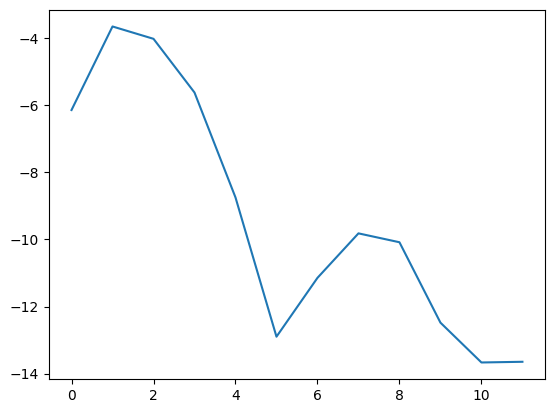

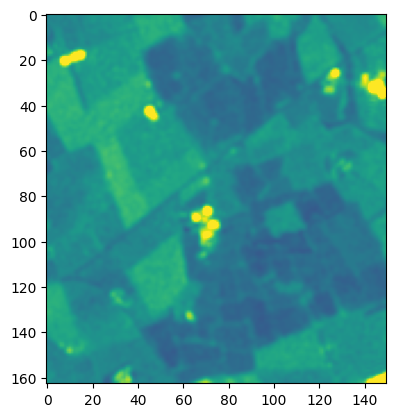

In [7]:
import numpy as np
import matplotlib.pyplot as plt

vv = ds["S1-SIGMA0-VV"].values.astype(np.float32)

vv[vv == 65535] = np.nan
vv = 20 * np.log10(vv) - 83

print(vv[:, idx, idy])
plt.plot(vv[:, idx, idy])
plt.show()

plt.imshow(np.nanmean(vv, axis=0), vmin=-20, vmax=0)

#### METEO

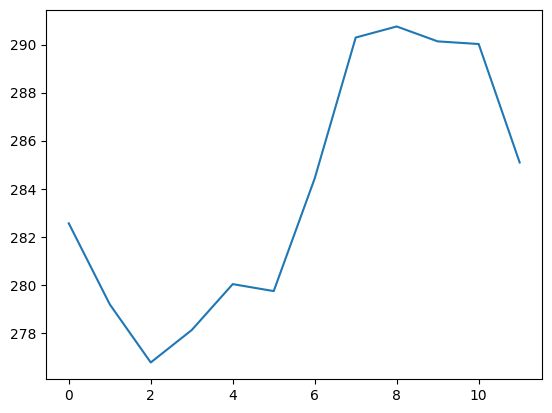

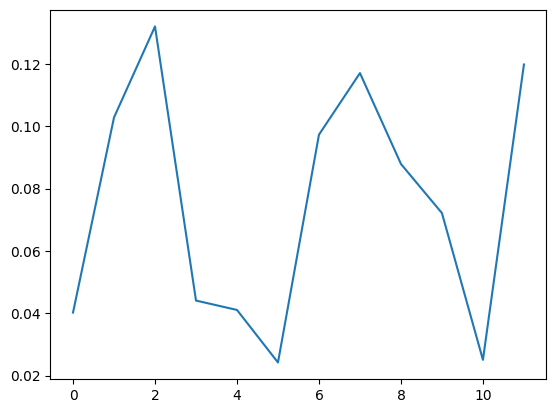

In [8]:
tmean = ds["AGERA5-TMEAN"].values
precip = ds["AGERA5-PRECIP"].values

tmean = tmean / 100.0
precip = precip / (100.0 * 1000.0)

plt.plot(tmean[:, idx, idy])
plt.show()

plt.plot(precip[:, idx, idy])
plt.show()

#### DEM

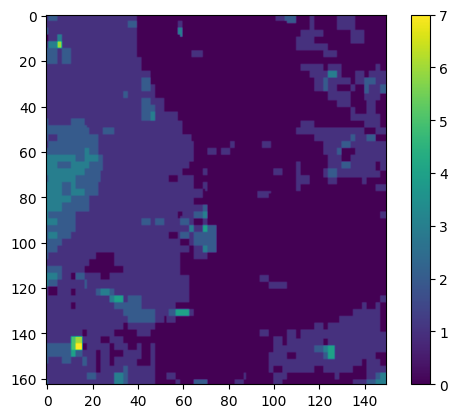

In [9]:
dem = ds["COP-DEM"].values.astype(np.float32)
dem[dem == 65535] = np.nan

plt.imshow(dem[0, ...])
plt.colorbar()

### Sanity checks on presto embeddings for cropland and crop type

In [38]:
from openeo_gfmap.features.feature_extractor import (
    EPSG_HARMONIZED_NAME,
    apply_feature_extractor_local,
)
from worldcereal.openeo.feature_extractor import PrestoFeatureExtractor

arr = ds.to_array(dim="bands").drop_sel(bands="crs").astype("uint16")


PRESTO_URL_CROPTYPE = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct-30D_test.pt"
PRESTO_URL_CROPLAND = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference/presto.pt"

features_cropland = apply_feature_extractor_local(
    PrestoFeatureExtractor,
    arr,
    parameters={
        EPSG_HARMONIZED_NAME: 32631,
        "ignore_dependencies": True,
        "presto_model_url": PRESTO_URL_CROPLAND,
    },
)

features_croptype = apply_feature_extractor_local(
    PrestoFeatureExtractor,
    arr,
    parameters={
        EPSG_HARMONIZED_NAME: 32631,
        "ignore_dependencies": True,
        "presto_model_url": PRESTO_URL_CROPTYPE,
    },
)

INFO:PrestoFeatureExtractor:`ignore_dependencies` flag is set to True. Make sure that Presto and its dependencies are available on the runtime environment
INFO:PrestoFeatureExtractor:Extracting presto features
INFO:PrestoFeatureExtractor:`ignore_dependencies` flag is set to True. Make sure that Presto and its dependencies are available on the runtime environment
INFO:PrestoFeatureExtractor:Extracting presto features


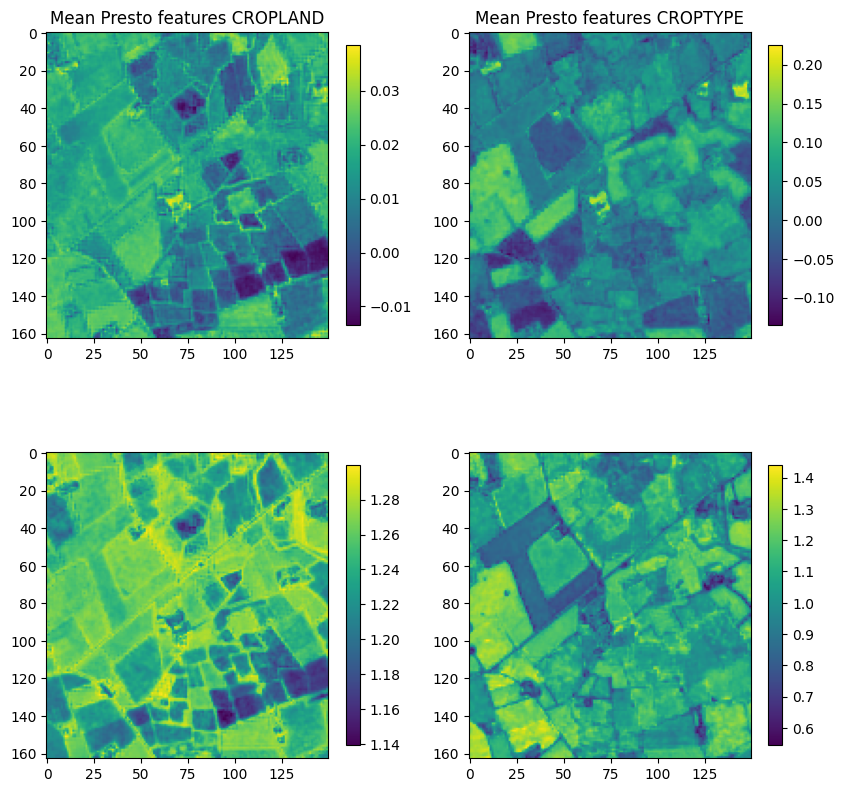

In [57]:
# plt.imshow(features.values[7,:,:])
# plt.plot(features.values[:,0,0])

f, ax = plt.subplots(2, 2, figsize=(10, 10))
avg_cropland = ax[0, 0].imshow(np.mean(features_cropland, axis=0))
f.colorbar(avg_cropland, shrink=0.8)
ax[0, 0].set_title("Mean Presto features CROPLAND")
avg_croptype = ax[0, 1].imshow(np.mean(features_croptype, axis=0))
f.colorbar(avg_croptype, shrink=0.8)
ax[0, 1].set_title("Mean Presto features CROPTYPE")
std_cropland = ax[1, 0].imshow(np.std(features_cropland, axis=0))
f.colorbar(std_cropland, shrink=0.8)
# ax[0,0].set_title('STD Presto features CROPLAND')
std_croptype = ax[1, 1].imshow(np.std(features_croptype, axis=0))
f.colorbar(std_croptype, shrink=0.8)

# ax[0,0].set_title('STD Presto features CROPTYPE')

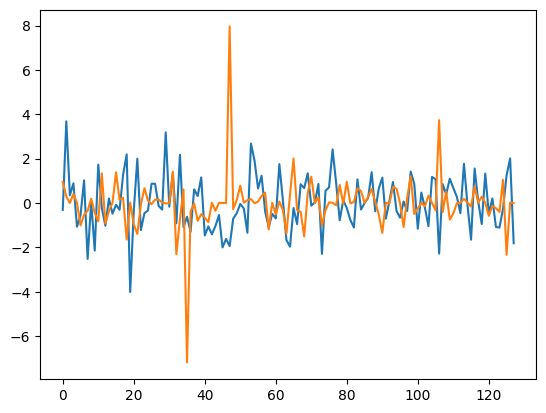

In [58]:
plt.plot(features_cropland[:, idx, idy])
plt.plot(features_croptype[:, idx, idy])

### CatBoost inference checks

In [59]:
import onnxruntime as ort
import requests

catboost_cropland_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference/wc_catboost.onnx"
catboost_croptype_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct-30D_test_CROPTYPE9.onnx"
catboost_cropland = ort.InferenceSession(
    requests.get(catboost_cropland_url, timeout=120).content
)
catboost_croptype = ort.InferenceSession(
    requests.get(catboost_croptype_url, timeout=120).content
)

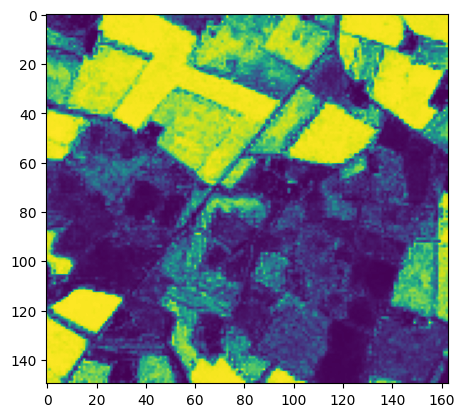

In [118]:
outputs = catboost_cropland.run(
    None,
    {
        "features": features_cropland.transpose("bands", "x", "y")
        .stack(xy=["x", "y"])
        .transpose()
        .values
    },
)
prediction_values = [sublist["True"] for sublist in outputs[1]]
binary_labels = np.array(prediction_values) >= 0.5
binary_labels = binary_labels.astype("uint8")
prediction_values = np.array(prediction_values) * 100.0

plt.imshow(
    prediction_values.reshape(features_cropland.shape[2], features_cropland.shape[1])
)

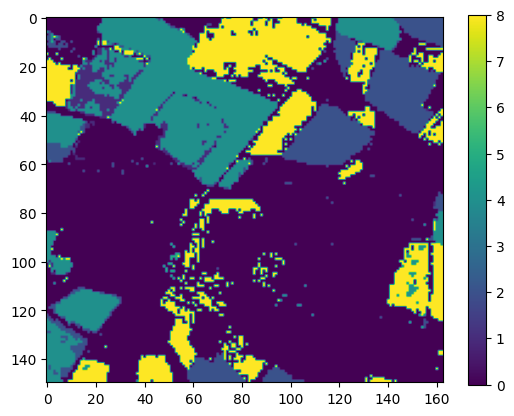

In [117]:
LUT = {
    "barley": 1,
    "maize": 2,
    "millet_sorghum": 3,
    "other_crop": 4,
    "rapeseed_rape": 5,
    "soy_soybeans": 6,
    "sunflower": 7,
    "wheat": 8,
}

outputs = catboost_croptype.run(
    None,
    {
        "features": features_croptype.transpose("bands", "x", "y")
        .stack(xy=["x", "y"])
        .transpose()
        .values
    },
)


# Extract classes as INTs and probability of winning class values
labels = np.zeros((len(outputs[0]),), dtype=np.uint16)
for i, (label, prob) in enumerate(zip(outputs[0], outputs[1])):
    labels[i] = LUT[label]


labels[binary_labels == 0] = 0

plt.imshow(labels.reshape(features_croptype.shape[2], features_croptype.shape[1]))
plt.colorbar()

In [108]:
import pandas as pd

pd.DataFrame(labels).value_counts()

0
0    14747
4     3763
8     3393
2     2098
1      423
5       25
7        1
Name: count, dtype: int64

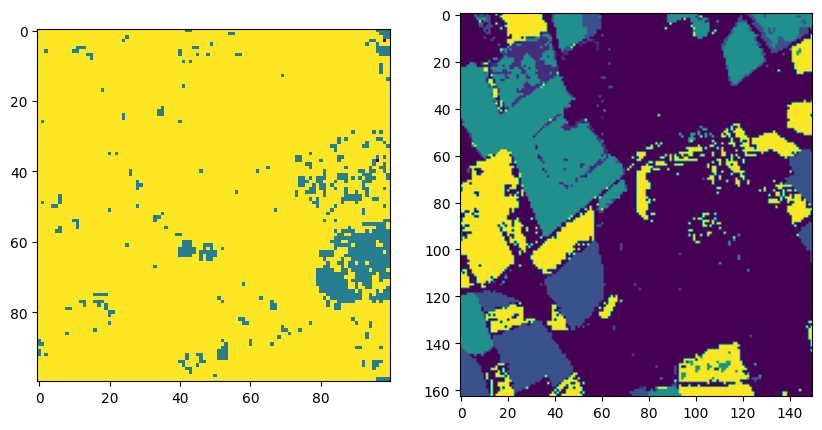

In [7]:
import matplotlib.pyplot as plt

croptype = xr.open_dataarray(
    "/home/kristofvt/git/worldcereal-classification/scripts/inference/test_classification_croptype.nc"
)
croptype_local = xr.open_dataarray(
    "/home/kristofvt/test_classification_croptype_local.nc"
)

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(croptype.values[0, ...])
ax[1].imshow(croptype_local.values[0, ...])

In [105]:
np.unique(croptype_local.values[0, ...])

array([1, 2, 4, 5, 7, 8], dtype=uint16)